In [1]:
#IMPORT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import corner
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA


In [2]:
#GENERAL OUTLINE
#
# import data and successfully extract from .txt using pandas DONE
#
# data exploration; look into dimensionality reduction (LOOP BACK) DONE
#
# when cleared, proceed to SVM for classification DONE
#
# attempt to foil the fact that 98% of the data is useless via weights, regularization
#
# 

In [3]:
###csv so automatic reading works.
###Remember to only read a limited number of rows when exploring to avoid crashes!
###Further addendum: It suddenly began working. No need to load partial data now
datatest = pd.read_csv('table_irsa_catalog_search_results(1).csv', on_bad_lines='warn')
###Drops rows with negative and zero values for our fluxes
datatest = datatest.drop(datatest.index[datatest['ir1_flux_c'] <= 0])
datatest = datatest.drop(datatest.index[datatest['ir2_flux_c'] <= 0])
datatest = datatest.drop(datatest.index[datatest['ir3_flux_c'] <= 0])
datatest = datatest.drop(datatest.index[datatest['ir4_flux_c'] <= 0])
datatest = datatest.drop(datatest.index[datatest['mp1_flux_c'] <= 0])

In [4]:
pd.set_option('display.max_colwidth', 500) #to stop curtailing of data

In [5]:
datatest.describe()

ra            dec     ir1_flux_c   ir1_d_flux_c  \
count  598578.000000  598578.000000  598578.000000  598578.000000   
mean      218.350056     -20.238826       1.315107       0.084163   
std        69.324435      27.218183      29.677483       2.978345   
min        51.076973     -78.229538       0.000001       0.000030   
25%       235.464401     -34.807583       0.019900       0.005460   
50%       245.492798     -24.287815       0.049000       0.007060   
75%       248.418465      -0.130489       0.128000       0.010700   
max       277.667328      32.976467    8000.000000    1100.000000   

          ir2_flux_c   ir2_d_flux_c     ir3_flux_c   ir3_d_flux_c  \
count  598578.000000  598578.000000  598578.000000  598578.000000   
mean        0.888998       0.054911       0.765612       0.076940   
std        20.301463       1.337579      21.200348       1.391463   
min         0.000001       0.000023       0.000001       0.000131   
25%         0.015600       0.006360       0.019200       0.032000   
50%         0.035500       0.007850       0.040000       0.040000   
75%         0.089800       0.010200       0.077100       0.046500   
max      3960.000000     358.000000    5500.000000     433.000000   

          ir4_flux_c   ir4_d_flux_c     mp1_flux_c  mp1_d_flux_c  
count  598578.000000  598578.000000  598578.000000  598578.00000  
mean        0.583351       0.084813       0.717619       0.41173  
std        18.593867       1.227259      29.250333       3.62904  
min         0.000001       0.004460       0.000001       0.08410  
25%         0.016000       0.043700       0.062400       0.26900  
50%         0.033900       0.053400       0.135000       0.32700  
75%         0.069100       0.061200       0.249000       0.37300  
max      3830.000000     361.000000    6860.000000    1150.00000

In [6]:
datatest.columns

Index(['c2d_id', 'ra', 'dec', 'object_type', 'ir1_flux_c', 'ir1_d_flux_c',
       'ir1_q_det_c', 'ir2_flux_c', 'ir2_d_flux_c', 'ir2_q_det_c',
       'ir3_flux_c', 'ir3_d_flux_c', 'ir3_q_det_c', 'ir4_flux_c',
       'ir4_d_flux_c', 'ir4_q_det_c', 'mp1_flux_c', 'mp1_d_flux_c',
       'mp1_q_det_c'],
      dtype='object')

In [7]:
#print(datatest['object_type'][:10])
###Takes every "object type" string and turns it into a unique integer 
###Of base 36
###Explicit connection does not matter, just needs to be "unique" so we can tel matplot to use unique colors
colors = [int(re.sub('\W', '', string), 36) for string in datatest['object_type']]
#print(colors[:10])
#print(datatest['object_type'].str[:3].unique().tolist())

In [8]:
def simplelabel(row):
    '''
    Takes in a row in the dataset. Reads the first 3 letters in the object type, and
    assigns a numerical value based on classification.
    0's are inconclusive in some way, 1's are stars,
    2's are galaxies, 3's are YSOs.
    If it fails, it returns 4; but that has not happened in testing.

    Takes the row from the C2D dataset.
    Returns an integer which must then be used to add an additional column.
    '''
    type = row['object_type'][:3]
    #remove "non interesting" sources
    #or confusing ones with no clear provenance
    if type == 'one':
        return 0
    if type == 'two':
        return 0
    if type == 'red':
        return 0
    if type == 'PAH':
        return 0
    #designate stars
    if type == 'sta':
        return 1
    #designate galaxies
    if type == 'Gal':
        return 2
    #designate YSOs
    if type == 'YSO':
        return 3
    #inconclusive morphologies
    if type == 'fla':
        return 0
    if type == 'cup':
        return 0
    if type == 'ris':
        return 0
    if type == 'fal':
        return 0
    return 4

In [9]:
###Adds new column into dataset, from the above function
datatest['numtype'] = datatest.apply(simplelabel, axis=1)

In [10]:
###Check out proportions of values; note how many are defined as inconclusive
###And also check for 4's (failures)
print(datatest['numtype'].unique().tolist())
print(datatest['numtype'].value_counts())

[0, 1, 2, 3]
numtype
0    454197
1    140329
2      2965
3      1087
Name: count, dtype: int64


In [11]:
###Now drop all inconclusive rows
datatest = datatest.drop(datatest.index[datatest['numtype'] == 0])

In [12]:
datatest.describe()

ra            dec     ir1_flux_c   ir1_d_flux_c  \
count  144381.000000  144381.000000  144381.000000  144381.000000   
mean      229.618357     -22.931583       5.302005       0.326341   
std        58.554049      25.627650      60.247826       6.057572   
min        51.096821     -78.229538       0.001220       0.002630   
25%       240.045746     -38.433178       0.177000       0.011500   
50%       245.480484     -24.410429       0.326000       0.019100   
75%       249.836166      -0.176496       0.907000       0.048700   
max       277.666534      32.972988    8000.000000    1100.000000   

          ir2_flux_c   ir2_d_flux_c     ir3_flux_c   ir3_d_flux_c  \
count  144381.000000  144381.000000  144381.000000  144381.000000   
mean        3.570255       0.202236       3.042933       0.183543   
std        41.189997       2.711268      43.036855       2.587201   
min         0.000383       0.003150       0.000004       0.000191   
25%         0.121000       0.009700       0.085700       0.030300   
50%         0.222000       0.014400       0.146000       0.037300   
75%         0.609000       0.033300       0.432000       0.051400   
max      3960.000000     358.000000    5500.000000     369.000000   

          ir4_flux_c   ir4_d_flux_c     mp1_flux_c   mp1_d_flux_c  \
count  144381.000000  144381.000000  144381.000000  144381.000000   
mean        2.235395       0.162438       2.095330       0.534772   
std        36.775939       2.257443      55.674164       6.103550   
min         0.000003       0.012700       0.000001       0.136000   
25%         0.049500       0.041900       0.061900       0.262000   
50%         0.096400       0.052900       0.135000       0.320000   
75%         0.277000       0.063300       0.255000       0.373000   
max      3830.000000     271.000000    6860.000000    1150.000000   

             numtype  
count  144381.000000  
mean        1.035593  
std         0.222225  
min         1.000000  
25%         1.000000  
50%         1.000000  
75%         1.000000  
max         3.000000

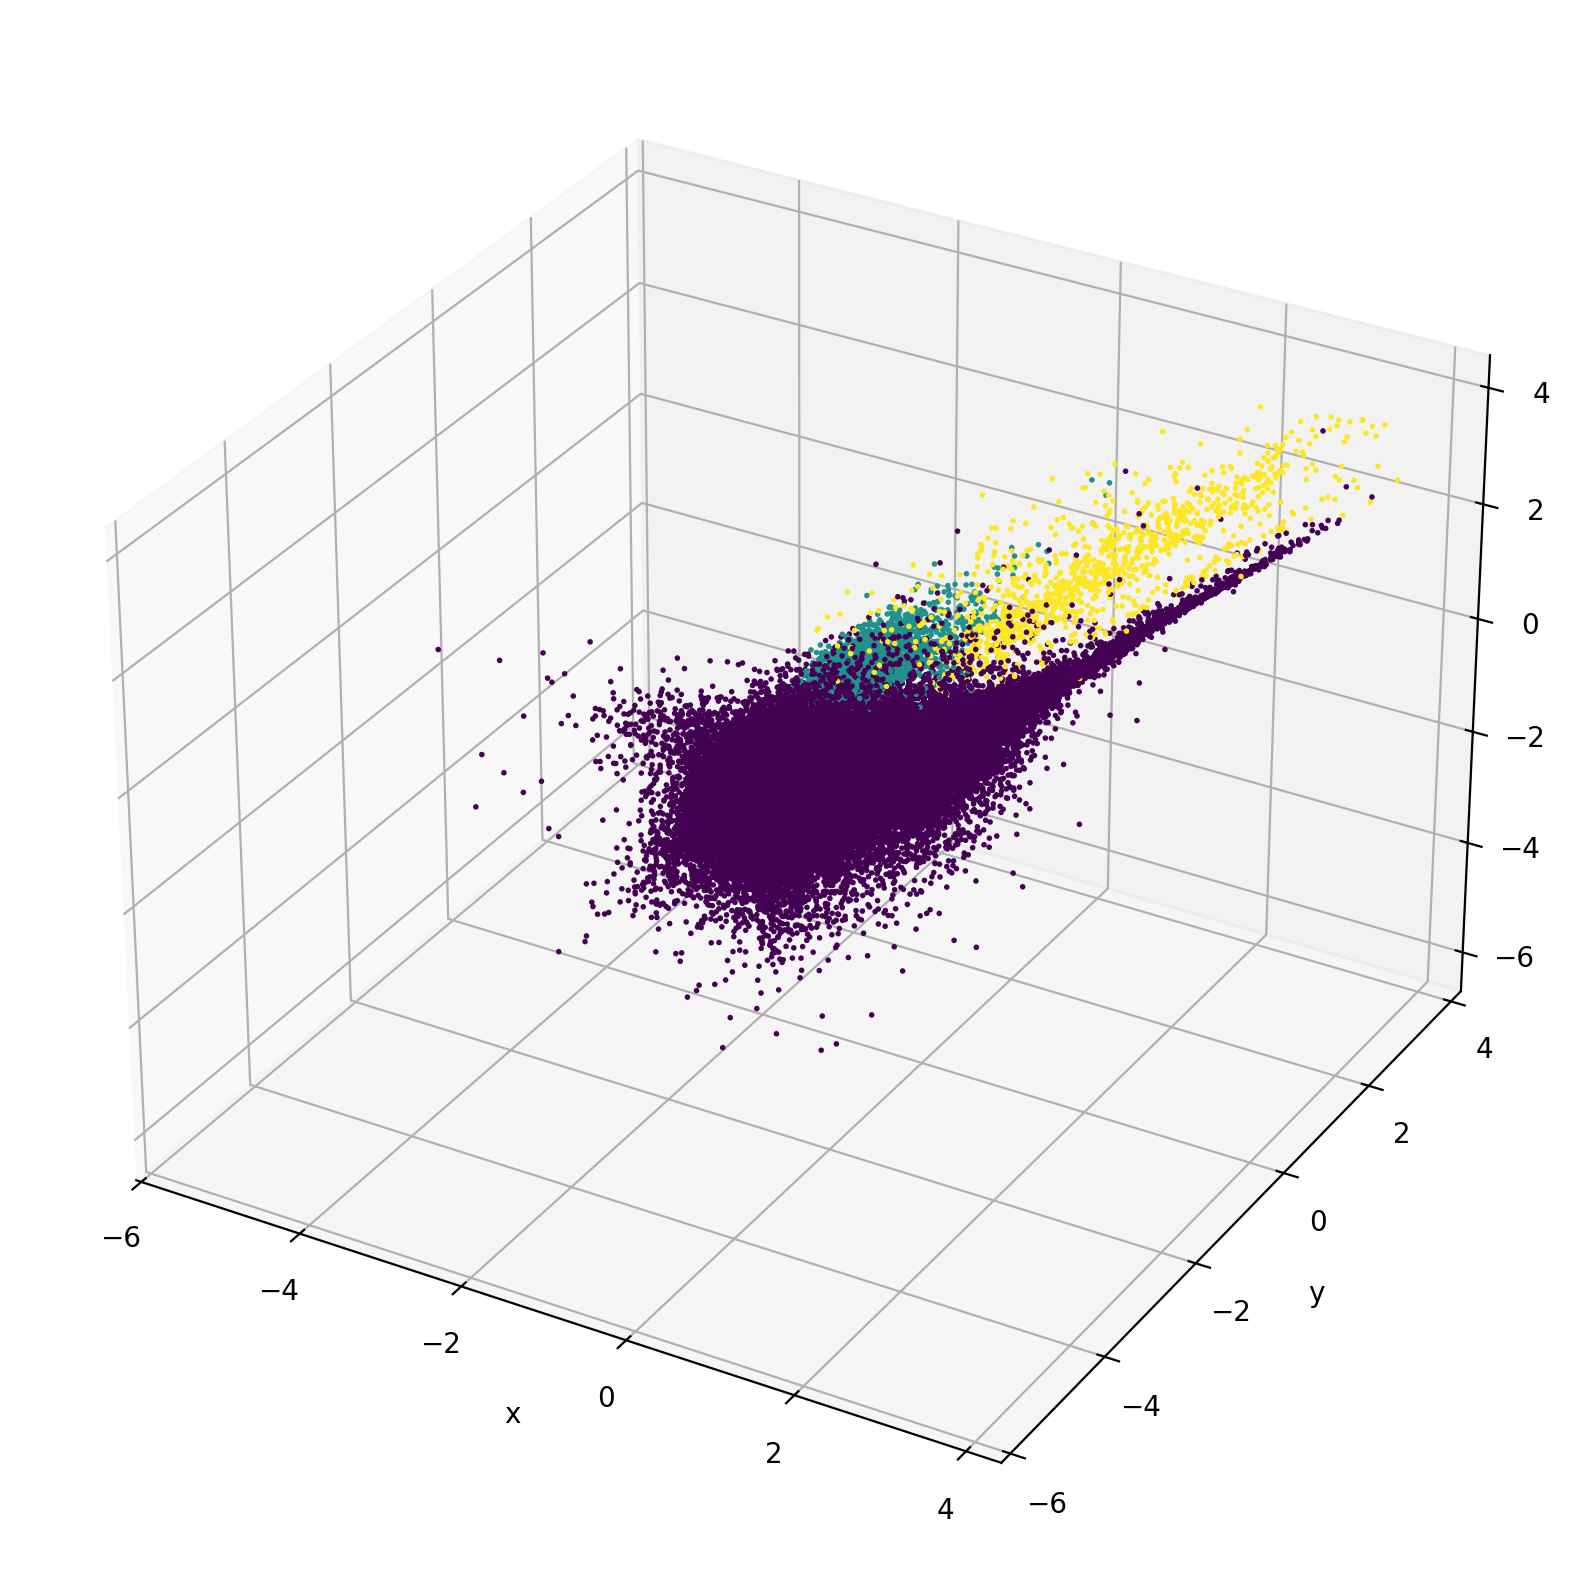

In [13]:
###3D plot of IR3, IR4, MIPS1
fig = plt.figure(figsize=(10,10), dpi=200)
ax = fig.add_subplot(projection='3d')

ax.scatter(np.log10(datatest['ir3_flux_c']), np.log10(datatest['ir4_flux_c']), np.log10(datatest['mp1_flux_c']), c=datatest['numtype'], alpha=1, s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#ax.view_init(azim=-90)

plt.show()

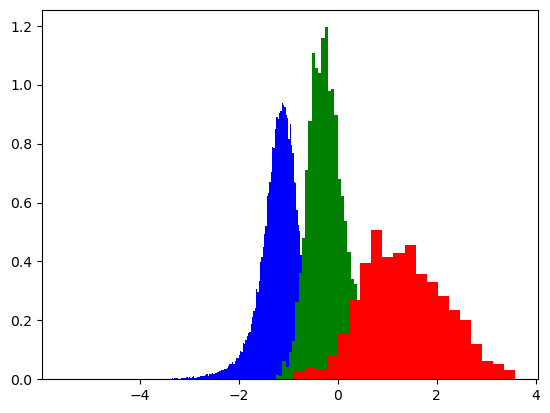

In [14]:
###Histogram construction over one axis
plt.hist(np.log10(datatest.loc[datatest['numtype'] == 1, 'ir4_flux_c']), bins='auto', density=True, color='blue')
plt.hist(np.log10(datatest.loc[datatest['numtype'] == 2, 'ir4_flux_c']), bins='auto', density=True, color='green')
plt.hist(np.log10(datatest.loc[datatest['numtype'] == 3, 'ir4_flux_c']), bins='auto', density=True, color='red')
plt.show()

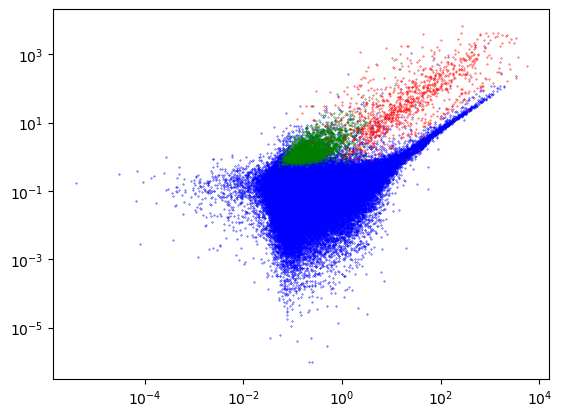

In [15]:
###2d scatter plot alternative
plt.scatter(np.array(datatest.loc[datatest['numtype'] == 1, 'ir3_flux_c']),np.array(datatest.loc[datatest['numtype'] == 1, 'mp1_flux_c']), s=.1, c='blue')
plt.scatter(np.array(datatest.loc[datatest['numtype'] == 2, 'ir3_flux_c']),np.array(datatest.loc[datatest['numtype'] == 2, 'mp1_flux_c']), s=.1, c='green')
plt.scatter(np.array(datatest.loc[datatest['numtype'] == 3, 'ir3_flux_c']),np.array(datatest.loc[datatest['numtype'] == 3, 'mp1_flux_c']), s=.1, c='red')
plt.loglog()
plt.show()

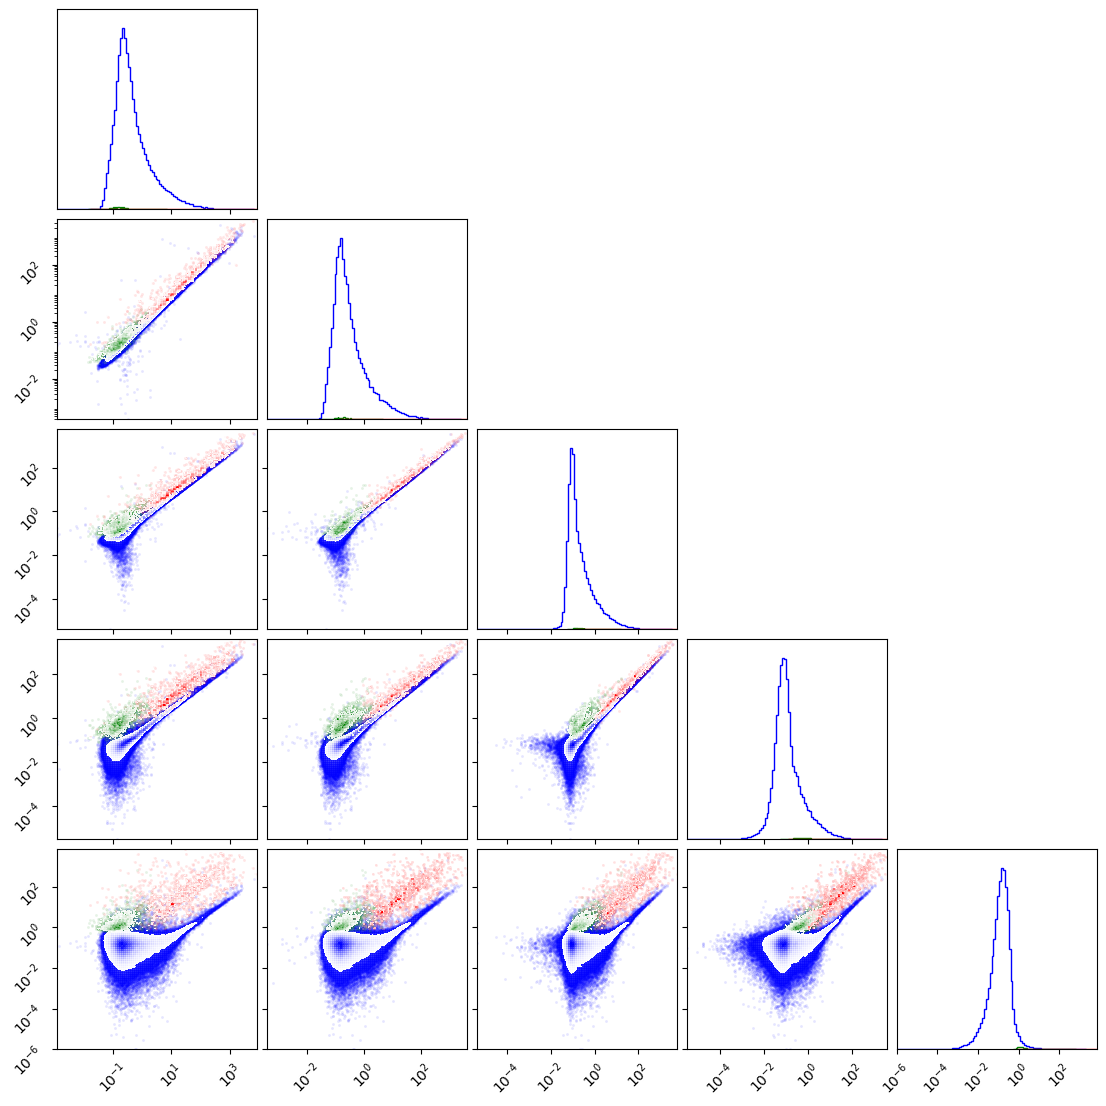

In [16]:
###Disgusting and abortive attempt at a corner plot. The high density of points makes the corner plot always 
###pixellate, and the arguments specifically designed to prevent that do not work, thus give up.
samplesStar = np.hstack((np.array(datatest.loc[datatest['numtype'] == 1, 'ir1_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 1, 'ir2_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 1, 'ir3_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 1, 'ir4_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 1, 'mp1_flux_c']).reshape(-1, 1)))
samplesGal = np.hstack((np.array(datatest.loc[datatest['numtype'] == 2, 'ir1_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 2, 'ir2_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 2, 'ir3_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 2, 'ir4_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 2, 'mp1_flux_c']).reshape(-1, 1)))
samplesYSO = np.hstack((np.array(datatest.loc[datatest['numtype'] == 3, 'ir1_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 3, 'ir2_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 3, 'ir3_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 3, 'ir4_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 3, 'mp1_flux_c']).reshape(-1, 1)))

figure = corner.corner(samplesStar, axes_scale='log', plot_contours=False, color='blue', bins=100)
corner.corner(samplesGal,fig=figure, axes_scale='log', plot_contours=False, color='green', bins=100)
corner.corner(samplesYSO,fig=figure, axes_scale='log', plot_contours=False, color='red', bins=100)
plt.show()

In [17]:
#Enough pain. Let us begin actually machine learning

In [18]:
###Using a simple linearSVC with no k-fold or anything as a test
###No statistical / testing element, simply to see if it works
clf = LinearSVC(dual = False)
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) 
X = np.vstack((np.log10(datatest['ir1_flux_c']), np.log10(datatest['ir2_flux_c']), np.log10(datatest['ir3_flux_c']),
              np.log10(datatest['ir4_flux_c']),np.log10(datatest['mp1_flux_c']))).T
print(X.shape)
print(X)
Y = np.array(datatest['numtype'])-1
print(Y)
clf.fit(X, Y)

(144381, 5)
[[ 0.06069784 -0.09908693 -0.25103714 -0.50584541 -1.24641694]
 [-1.13430394 -1.34294415 -1.35951856 -2.0619809  -0.75448733]
 [-0.35066514 -0.54668166 -0.7235382  -1.01502287 -1.18508682]
 ...
 [ 0.66745295  0.5171959   0.35602586  0.15836249 -0.78515615]
 [-0.91009489 -1.04769199 -1.26921772 -1.4867824  -0.61439373]
 [-0.79317412 -0.9625735  -1.11350927 -1.70774393 -1.01099538]]
[0 0 0 ... 0 0 0]


LinearSVC(dual=False)

In [22]:
#fauxgrid = np.linspace(-3, 3, 10)
#g = np.meshgrid(fauxgrid, fauxgrid, fauxgrid, fauxgrid, fauxgrid)
#Xnew = np.vstack([np.ravel(i) for i in g]).T

###Very important yet small line of code. Allows colors to be assigned based on the SVM prediction, for use in scatter plot
carray = clf.predict(np.array((np.log10(datatest['ir1_flux_c']), np.log10(datatest['ir2_flux_c']), np.log10(datatest['ir3_flux_c']),np.log10(datatest['ir4_flux_c']),np.log10(datatest['mp1_flux_c']))).T)

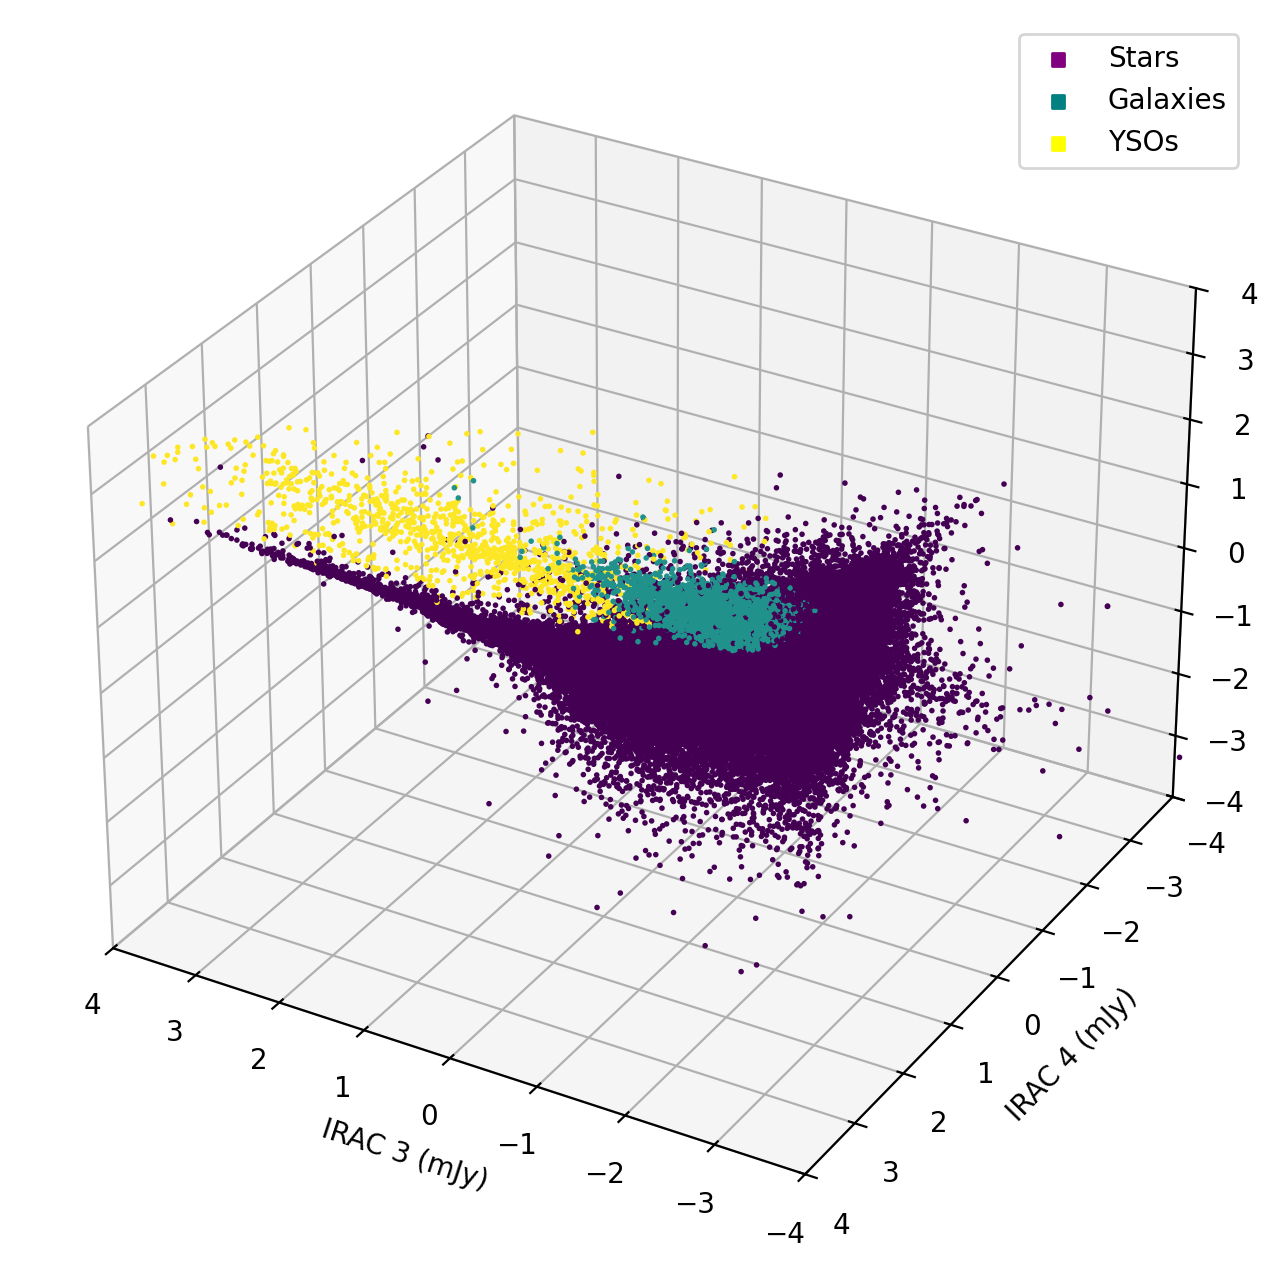

In [23]:
###3D plot of ORIGINAL data, flipped around
fig = plt.figure(figsize=(9,8), dpi=200)
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(np.log10(datatest['ir3_flux_c']), np.log10(datatest['ir4_flux_c']), np.log10(datatest['mp1_flux_c']), c=datatest['numtype'], alpha=1, s=1)
ax.set_xlabel('IRAC 3 (mJy)')
ax.set_ylabel('IRAC 4 (mJy)')
ax.set_zlabel('MIPS 1 (mJy)')
ax.set_xlim(4, -4)
ax.set_ylim(4, -4)
ax.set_zlim(-4, 4)
STR = ax.scatter([], [], color='purple', marker='s', ls='', label='Stars')
GAL = ax.scatter([], [], color='teal', marker='s', ls='', label='Galaxies')
YSO = ax.scatter([], [], color='yellow', marker='s', ls='', label='YSOs')
plt.legend(handles=[STR, GAL, YSO])
plt.show()

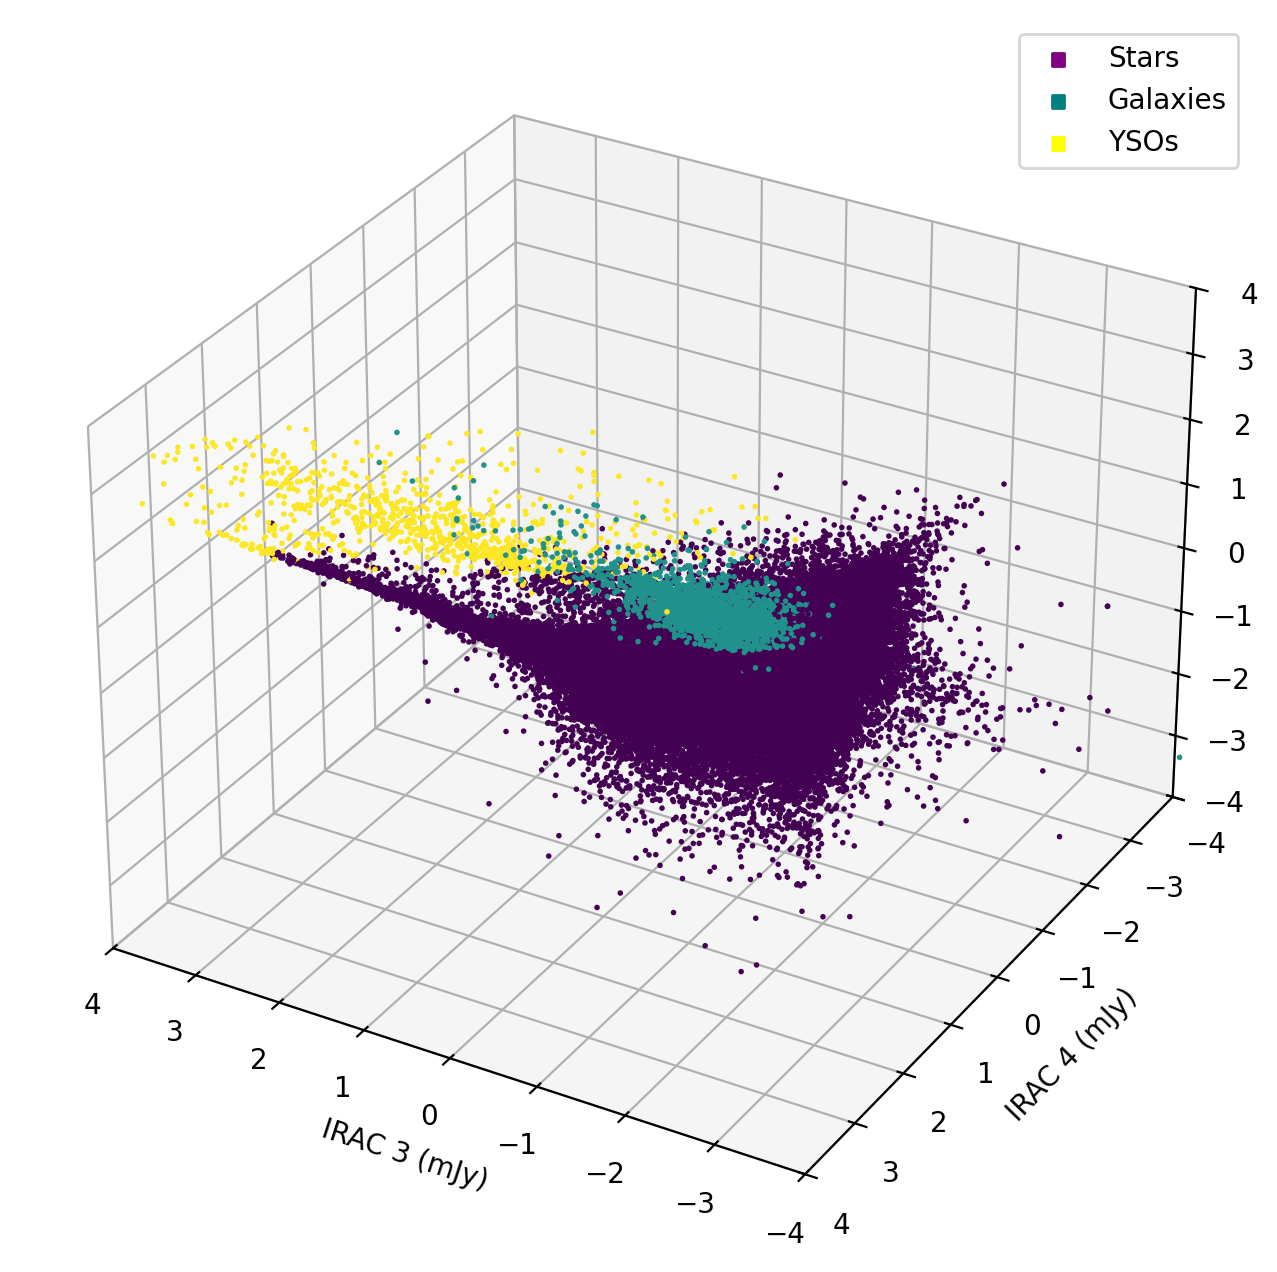

In [24]:
###3D plot of SVM'd data, with color points labeled appropriately
fig = plt.figure(figsize=(9,8), dpi=200)
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(np.log10(datatest['ir3_flux_c']), np.log10(datatest['ir4_flux_c']), np.log10(datatest['mp1_flux_c']), c=carray, alpha=1, s=1)
ax.set_xlabel('IRAC 3 (mJy)')
ax.set_ylabel('IRAC 4 (mJy)')
ax.set_zlabel('MIPS 1 (mJy)')
ax.set_xlim(4, -4)
ax.set_ylim(4, -4)
ax.set_zlim(-4, 4)
STR = ax.scatter([], [], color='purple', marker='s', ls='', label='Stars')
GAL = ax.scatter([], [], color='teal', marker='s', ls='', label='Galaxies')
YSO = ax.scatter([], [], color='yellow', marker='s', ls='', label='YSOs')
plt.legend(handles=[STR, GAL, YSO])
plt.show()

In [26]:
###Now for the real non-test machine learning.
###SVC with rbf kernel, stratified k-fold with 5 splits
###Also gives training and testing score
###Note suspicious score for later
clf = SVC(kernel='rbf')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) 

l_benchmark_lim = cross_validate(clf, X, Y, cv = cv, return_train_score = True)

print("Training score: {} +/- {}".format(
    np.round(l_benchmark_lim['train_score'].mean(),7), np.round(l_benchmark_lim['train_score'].std(), 7)))

print("Testing score: {} +/- {}".format(
    np.round(l_benchmark_lim['test_score'].mean(),7), np.round(l_benchmark_lim['test_score'].std(), 7)))

Training score: 0.9956383 +/- 0.000125
Testing score: 0.9955188 +/- 0.0004939


In [27]:
###use PCA to plot 2dlike

In [28]:
###vstacking to get it into a PCA'able form
X = np.vstack((np.log10(datatest['ir1_flux_c']), np.log10(datatest['ir2_flux_c']), np.log10(datatest['ir3_flux_c']),
              np.log10(datatest['ir4_flux_c']),np.log10(datatest['mp1_flux_c']))).T
pca = PCA(n_components=2)

XPCA = pca.fit_transform(X)


[[ 0.66434704 -0.49384688]
 [-1.73310863  0.50283389]
 [-0.22303067 -0.24446586]
 ...
 [ 1.98205263 -0.31064415]
 [-1.11379598  0.53870102]
 [-1.14172497  0.11058475]]


In [29]:
###Can now apply rbf kernel to PCA'd data; same ideas here too
clf = SVC(kernel='rbf')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) 

l_benchmark_lim = cross_validate(clf, XPCA, Y, cv = cv, return_train_score = True)

print("Training score: {} +/- {}".format(
    np.round(l_benchmark_lim['train_score'].mean(),7), np.round(l_benchmark_lim['train_score'].std(), 7)))

print("Testing score: {} +/- {}".format(
    np.round(l_benchmark_lim['test_score'].mean(),7), np.round(l_benchmark_lim['test_score'].std(), 7)))

Training score: 0.9907311 +/- 0.0001092
Testing score: 0.990629 +/- 0.0005026


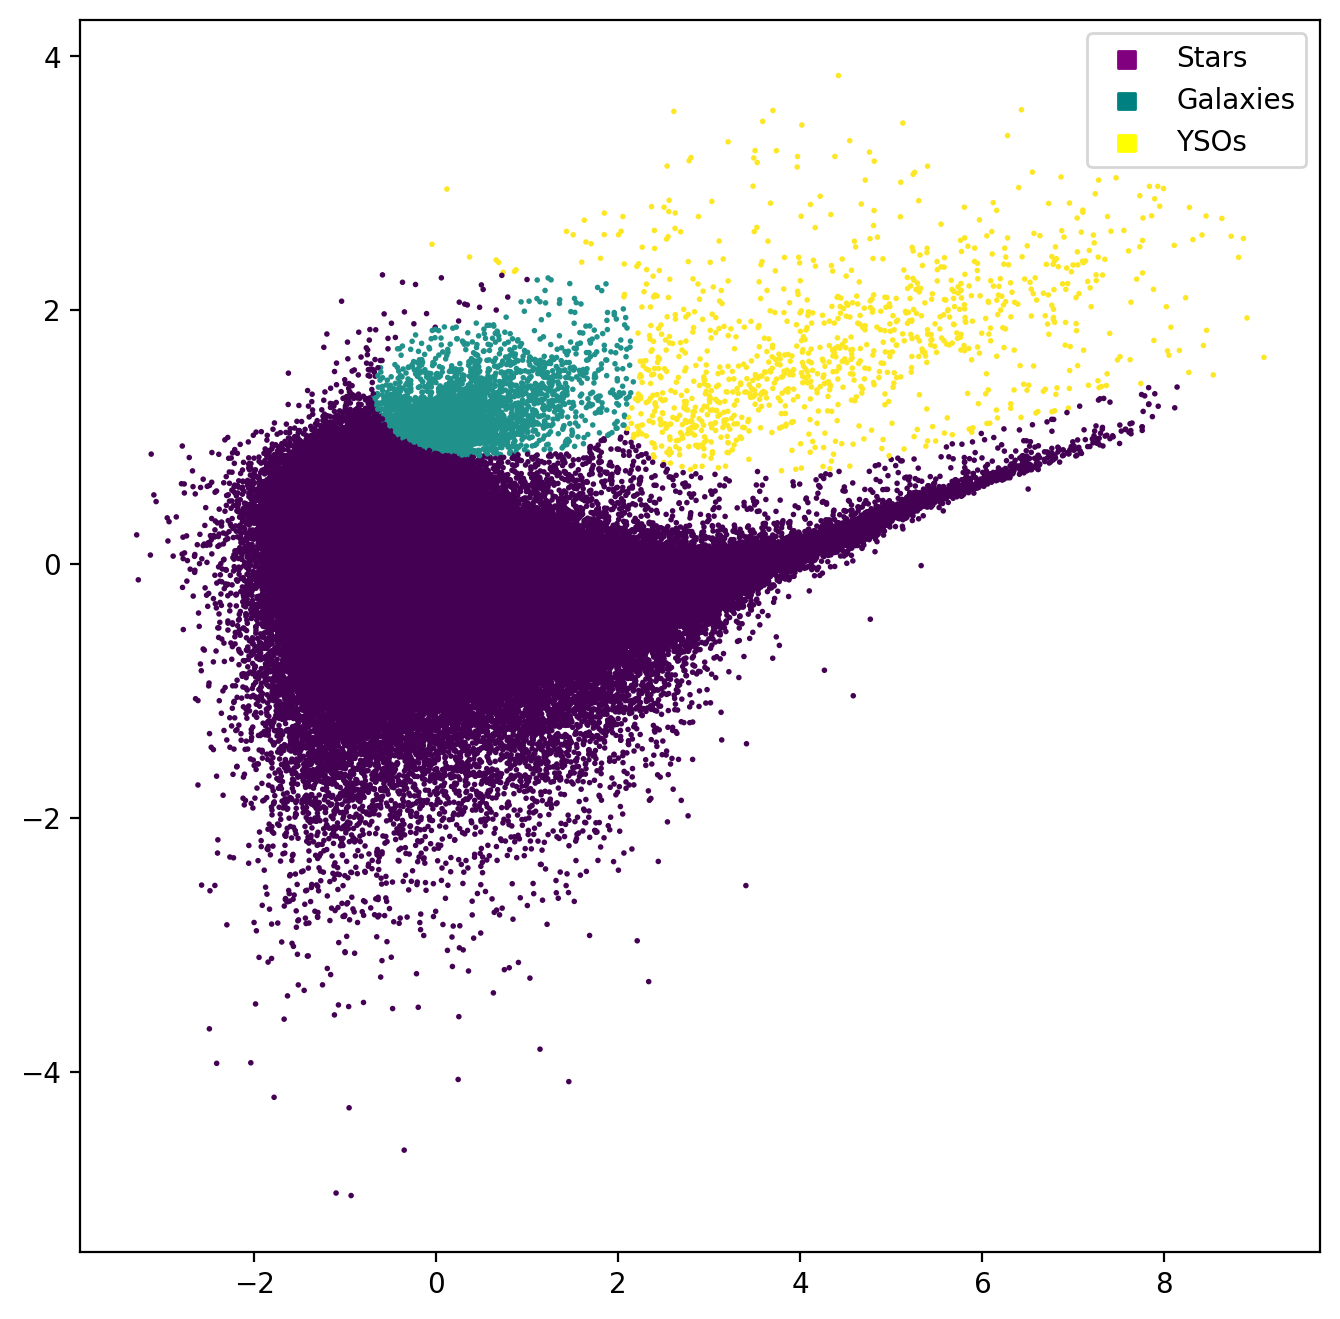

In [31]:
###Newly labelled PCA'd data
clf.fit(XPCA, Y)
###Note that carray here is rerun, so we're not just reusing the old stuff
carray = clf.predict(XPCA).T

fig = plt.figure(figsize=(8,8), dpi=200)
ax  = fig.add_subplot(111)

ax.scatter(XPCA[:,0],XPCA[:,1], c=carray, alpha=1, s=1)

STR = ax.scatter([], [], color='purple', marker='s', ls='', label='Stars')
GAL = ax.scatter([], [], color='teal', marker='s', ls='', label='Galaxies')
YSO = ax.scatter([], [], color='yellow', marker='s', ls='', label='YSOs')
plt.legend(handles=[STR, GAL, YSO])
plt.show()

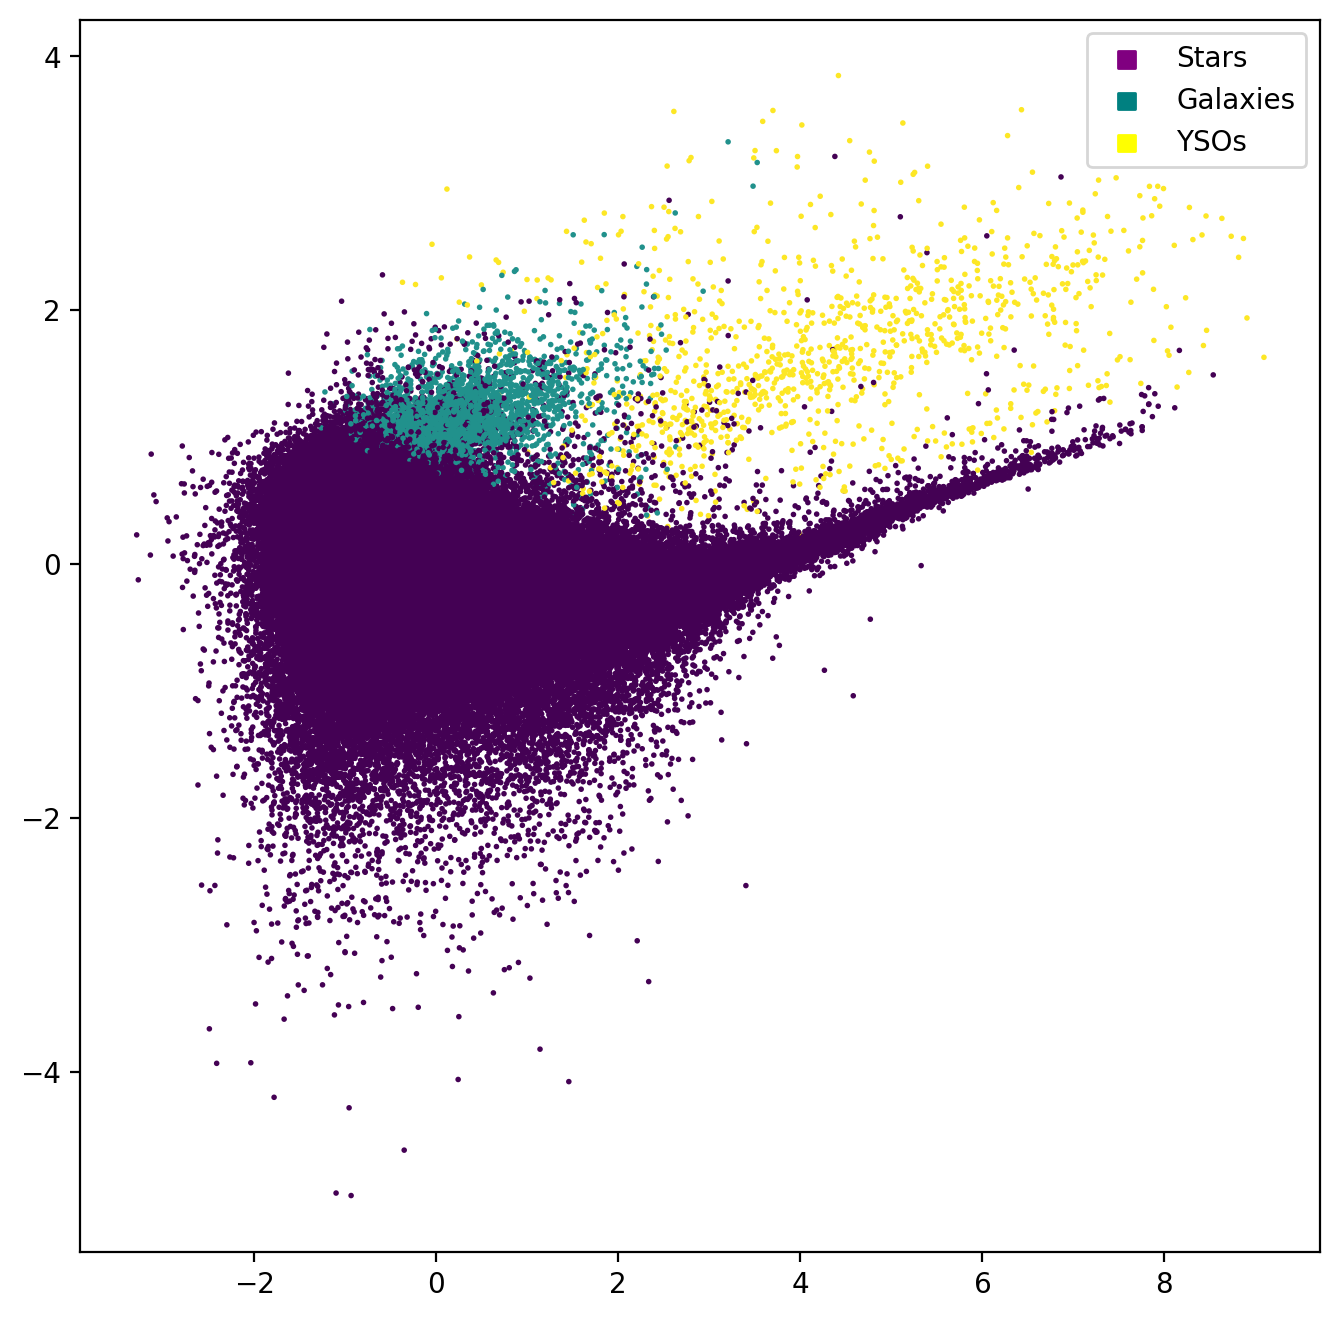

In [32]:
###"ORIGINAL" data after PCA
fig = plt.figure(figsize=(8,8), dpi=200)
ax  = fig.add_subplot(111)

ax.scatter(XPCA[:,0],XPCA[:,1], c=datatest['numtype'], alpha=1, s=1)
STR = ax.scatter([], [], color='purple', marker='s', ls='', label='Stars')
GAL = ax.scatter([], [], color='teal', marker='s', ls='', label='Galaxies')
YSO = ax.scatter([], [], color='yellow', marker='s', ls='', label='YSOs')
plt.legend(handles=[STR, GAL, YSO])

plt.show()

In [33]:
###the grand era of weights and regularization

In [34]:
###Let's use an rbf kernel 
###The key difference: assigning class weight as balanced,
###so that each class is weighed inversely to the count
clf = SVC(kernel='rbf', class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) 

l_benchmark_lim = cross_validate(clf, X, Y, cv = cv, return_train_score = True)

print("Training score: {} +/- {}".format(
    np.round(l_benchmark_lim['train_score'].mean(),7), np.round(l_benchmark_lim['train_score'].std(), 7)))

print("Testing score: {} +/- {}".format(
    np.round(l_benchmark_lim['test_score'].mean(),7), np.round(l_benchmark_lim['test_score'].std(), 7)))

Training score: 0.9851868 +/- 0.000295
Testing score: 0.985095 +/- 0.0009669


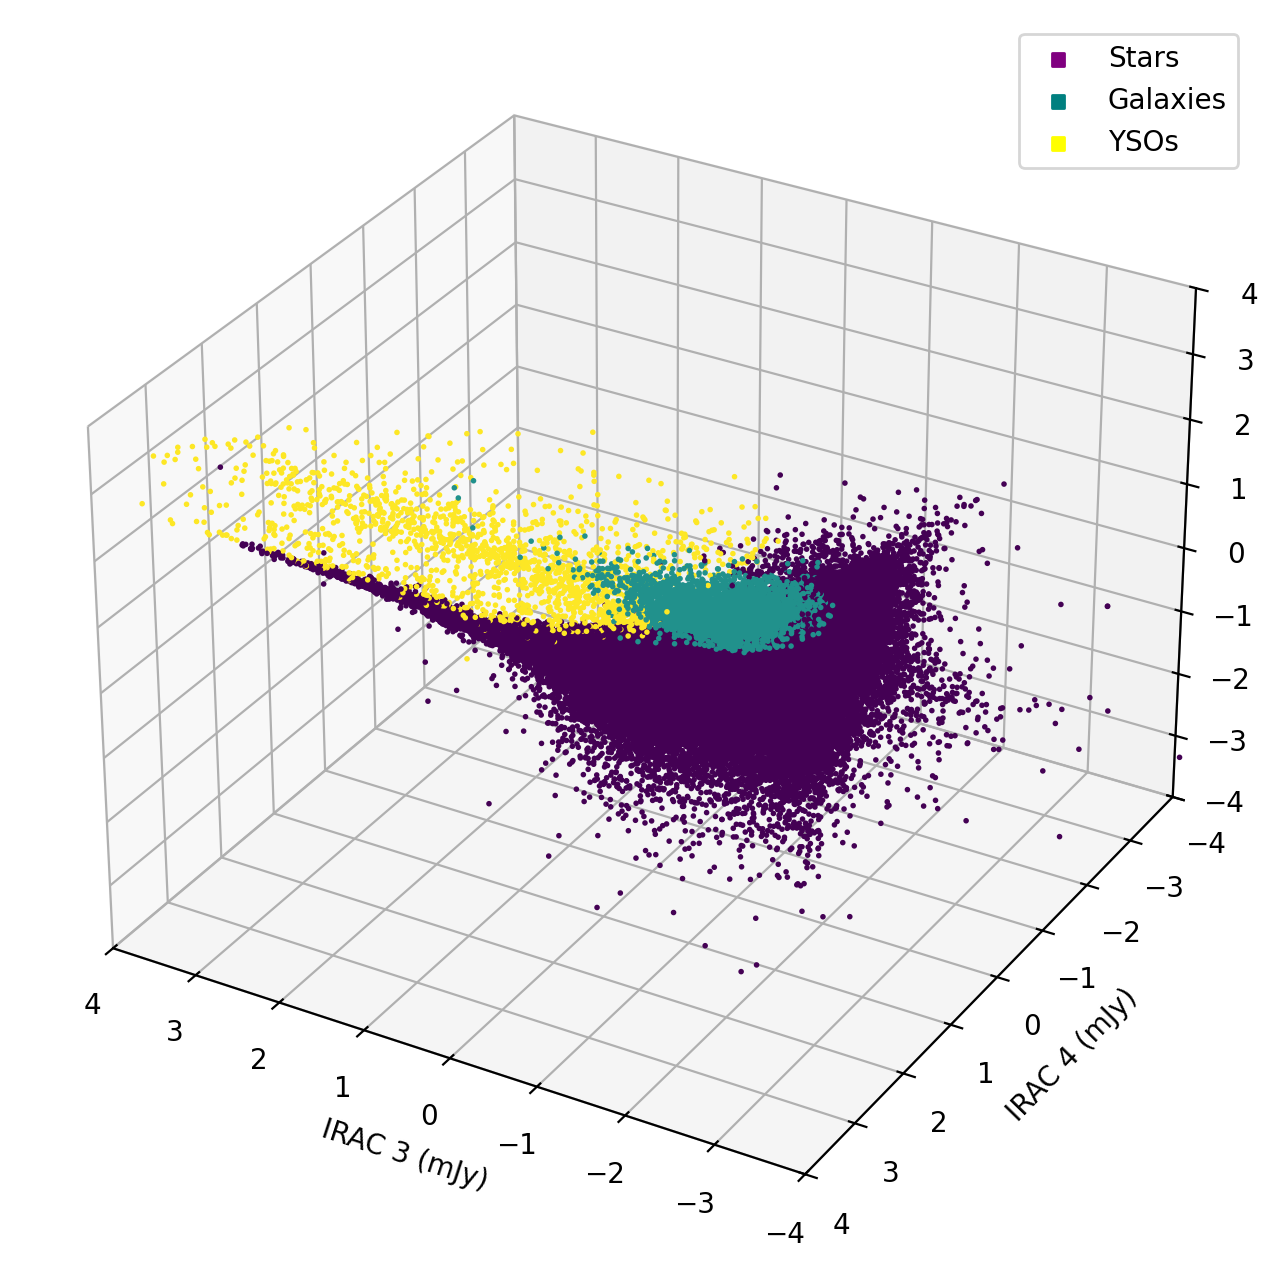

In [36]:
###Visualization
fig = plt.figure(figsize=(9,8), dpi=200)
ax  = fig.add_subplot(111, projection='3d')
clf.fit(X, Y)
carray = clf.predict(np.array((np.log10(datatest['ir1_flux_c']), np.log10(datatest['ir2_flux_c']), np.log10(datatest['ir3_flux_c']),np.log10(datatest['ir4_flux_c']),np.log10(datatest['mp1_flux_c']))).T)
ax.scatter(np.log10(datatest['ir3_flux_c']), np.log10(datatest['ir4_flux_c']), np.log10(datatest['mp1_flux_c']), c=carray, alpha=1, s=1)
ax.set_xlabel('IRAC 3 (mJy)')
ax.set_ylabel('IRAC 4 (mJy)')
ax.set_zlabel('MIPS 1 (mJy)')
ax.set_xlim(4, -4)
ax.set_ylim(4, -4)
ax.set_zlim(-4, 4)
STR = ax.scatter([], [], color='purple', marker='s', ls='', label='Stars')
GAL = ax.scatter([], [], color='teal', marker='s', ls='', label='Galaxies')
YSO = ax.scatter([], [], color='yellow', marker='s', ls='', label='YSOs')
plt.legend(handles=[STR, GAL, YSO])
plt.show()

In [38]:
###And what about applying rbf kernel to PCA'd data?
clf = SVC(kernel='rbf', class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) 

l_benchmark_lim = cross_validate(clf, XPCA, Y, cv = cv, return_train_score = True)

print("Training score: {} +/- {}".format(
    np.round(l_benchmark_lim['train_score'].mean(),7), np.round(l_benchmark_lim['train_score'].std(), 7)))

print("Testing score: {} +/- {}".format(
    np.round(l_benchmark_lim['test_score'].mean(),7), np.round(l_benchmark_lim['test_score'].std(), 7)))

Training score: 0.9791576 +/- 0.0005357
Testing score: 0.9793117 +/- 0.0008773


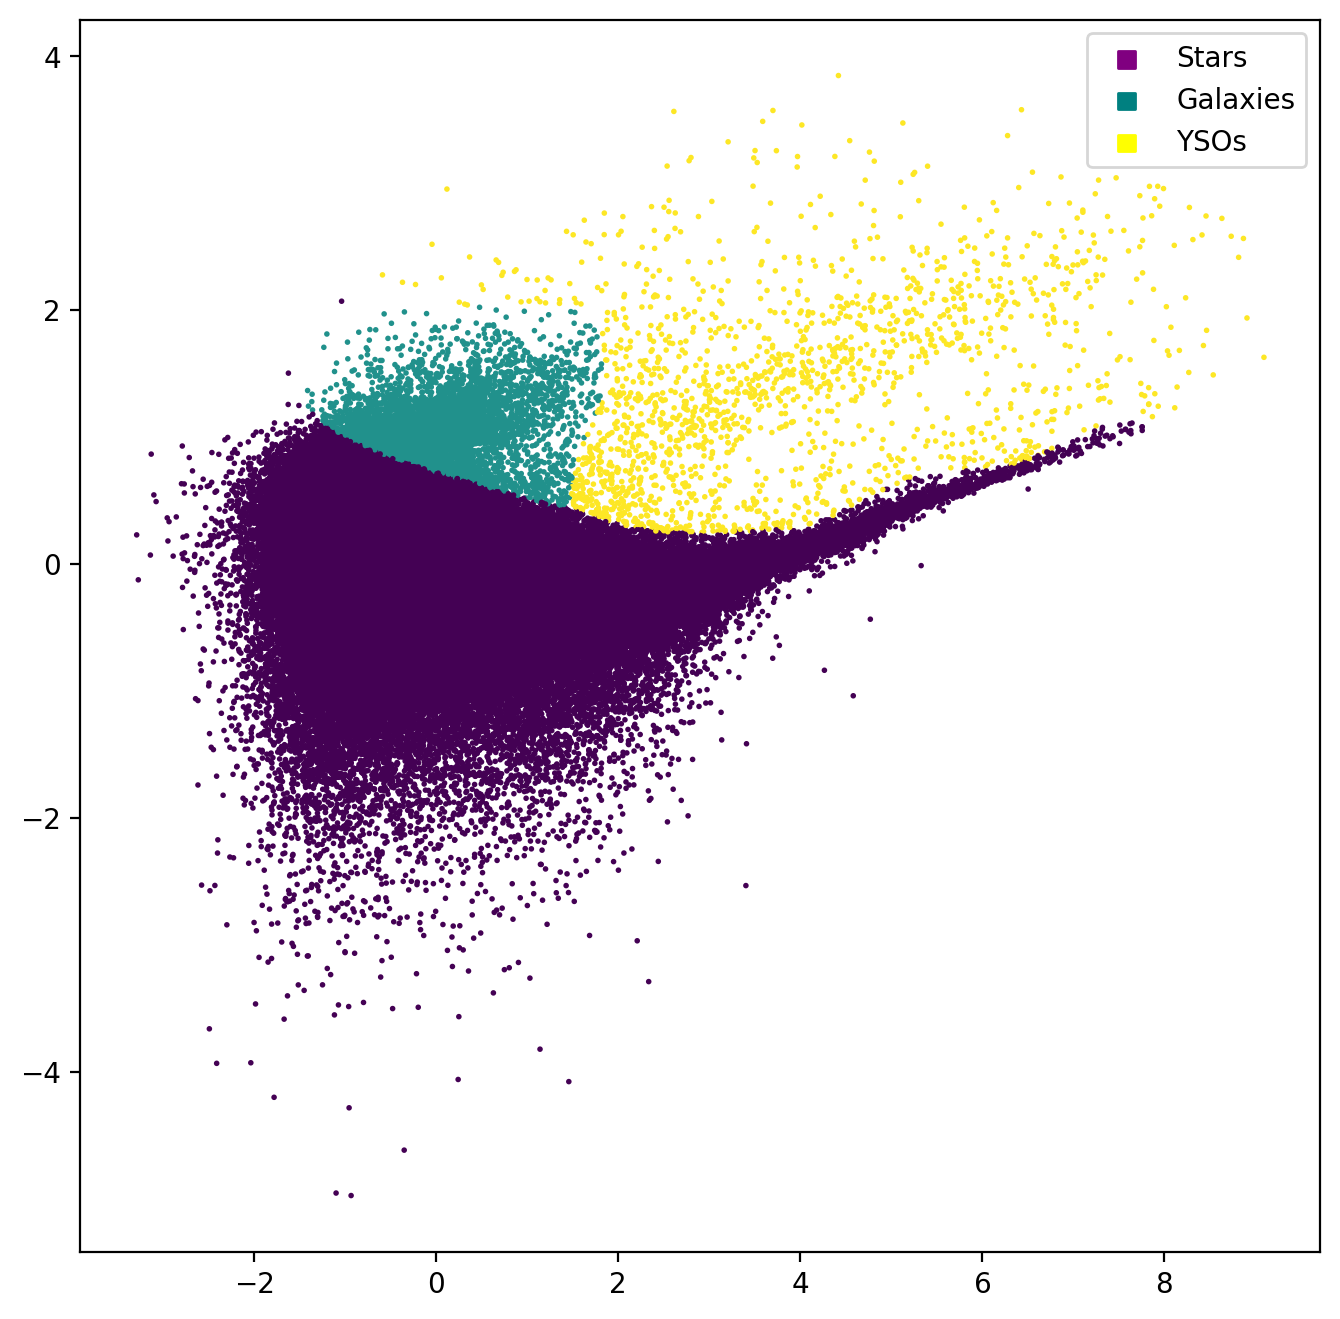

In [39]:
###Newly labelled PCA'd data
clf.fit(XPCA, Y)
###Note that carray here is rerun, so we're not just reusing the old stuff
carray = clf.predict(XPCA).T

fig = plt.figure(figsize=(8,8), dpi=200)
ax  = fig.add_subplot(111)

ax.scatter(XPCA[:,0],XPCA[:,1], c=carray, alpha=1, s=1)

STR = ax.scatter([], [], color='purple', marker='s', ls='', label='Stars')
GAL = ax.scatter([], [], color='teal', marker='s', ls='', label='Galaxies')
YSO = ax.scatter([], [], color='yellow', marker='s', ls='', label='YSOs')
plt.legend(handles=[STR, GAL, YSO])
plt.show()